# Predictions and data cleaning

Now that we found XGBoost is the optimal model, we can use it for predicting the label for every image in the dataset

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.utils import list_of_dict_to_dict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP

# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier

from sklearn import manifold, datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.dummy import DummyClassifier

def classification_complete_report(estimator, X, y_true, labels = None ,plot = True ): 
    y_pred = estimator.predict(X)
    y_pred_dummy = DummyClassifier().fit(X,y_true).predict(X)
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("No information rate: %.2f" % accuracy_score(y_true, y_pred_dummy) )
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true, labels = labels ,cmap = "Greys", xticks_rotation='vertical')
    

In [3]:
from skimage.util import crop

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

now lets load the data

In [4]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset_with_predictions.csv.gz")
metadata

,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1,B_cell,0.001350,Experiment_1 Donor_1,False,0
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1,T_cell,0.000959,Experiment_1 Donor_1,False,1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1,Dead_Cell,0.002358,Experiment_1 Donor_1,False,0
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1,T_cell,0.000502,Experiment_1 Donor_1,False,1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1,B_cell_with_small_area,0.028317,Experiment_1 Donor_1,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1,T_cell_with_signaling,0.259178,Experiment_4 Donor_9,False,1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1,B_cell,0.006382,Experiment_4 Donor_9,False,0
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1,T_cell_with_signaling,0.487638,Experiment_4 Donor_9,False,1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1,B_cell,0.082181,Experiment_4 Donor_9,False,2


In [5]:
metadata.file[0]

'/pstore/data/DS4/synapse_formation_full_data/Experiment_1/Donor_1/+SEA/Experiment_1_Donor_1_+SEA_5156.h5'

file             /pstore/data/DS4/synapse_formation_full_data/E...
experiment       Experiment_1Experiment_1Experiment_1Experiment...
donor            Donor_1Donor_1Donor_2Donor_2Donor_2Donor_2Dono...
condition        +SEAIsotype-SEA-SEAIsotypeTeplizumab-SEAIsotyp...
object_number                                             20389648
set              unlabeledunlabeledunlabeledunlabeledunlabeledu...
prediction       high_entropyout_of_focushigh_entropyDead_Cello...
entropy                                                 170.190121
key              Experiment_1 Donor_1Experiment_1 Donor_1Experi...
outlier          1111111111111111111111111111111111111111111111...
cluster                                                       1768
dtype: object
[741.0, 25.0, 36.0, 48.0, 38.0, 35.0] [864.3, 2416.0, 1848.2799999999988, 4055.0, 1069.2799999999988, 642.0699999999997]


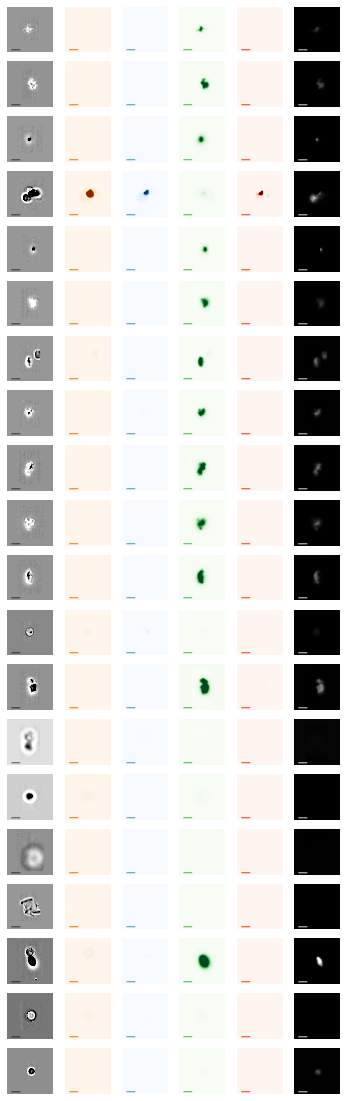

In [6]:

image_size = 128
channels_to_be_plotted = [0,3,4,5,6,7]
channel_colors = ["Greys","Oranges" ,"Blues","Greens","Reds","Greys_r"]

    

k = 20
indx = metadata.outlier == '1'
indx = indx & (metadata.cluster > 8)
indx = indx & (metadata.entropy > 1.1)
print(metadata.loc[indx, :].sum())
files = metadata.loc[indx, "file"].sample(k,replace=False)
files = files.str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

nrows = k
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*1, nrows*1 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.40)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.99)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.1)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.90)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] = vmax[j]
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()

plt.savefig('Supplementary Figure - sample outlier images.svg', bbox_inches="tight")

In [7]:
# metadata.outlier.sum()

In [11]:
indx = metadata.outlier == '1'
indx.sum()

18121

In [13]:
round(indx.mean(),2)

0.02